<a href="https://colab.research.google.com/github/emilycalvert/scripts_cite/blob/main/analisis_salud_bosque_ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Alistar entorno.

In [1]:
!pip install numpy
!pip install geopy
!pip install pandas
!pip install pyproj
!pip install geemap
!pip install timedelta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for timedelta: filename=timedelta-2020.12.3-py3-none-any.whl size=1554 sha256=04e6ed4135dc42ea5cb5e66ac802a6cc4a383a68bac26fc94e558f1c695eb60c
  Stored in directory: /root/.cache/pip/wheels/be/c0/1f/843bd73679dc7dfb26758c4effc6e273d3eebf2da2a35082b1
Successfully built timedelta


In [2]:
import ee
import time
import geemap
import datetime
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer, Proj, transform

# **Recopilar, Proceso Datos, y Analizar NDVI**

### **1. Autorizar e inicializar Earth Engine**
#### _Autenticar e inicializar la API de Google Earth Engine (GEE)._




- Conecte e inicialice con tu cuenta de earth engine y proyecto.

In [3]:
ee.Authenticate(auth_mode="notebook")
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=E3lICf85eKocigw-ShrYGq2U9_QOoYQlUhFBb4DNU5c&tc=FoNfo0Nd2IauTDuiCRyMTPP3rm7S_d4vn6nvAgcJuyo&cc=lhais41mRVe2bQYG_msKd-ZNe_yd2iONn4A2ZMXhpeg

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXm3S2DJGC1wPXYEKuX3HV7_ZrK5m5fL4QiwwlfHYDAi1ckTLXEsmMU

Successfully saved authorization token.


## **2. Cargar CSV**

#### _Cargue el archivo CSV que contiene las coordenadas y analícelo para crear puntos._

- Exporta tu hoja de cálculo con los vértices como csv. La integridad y uniformidad del documento original es importante. Si tiene dificultades en este paso, consulte el curso [aquí.](https://www.youtube.com/watch?v=uGx0PHD6o9M)

- Al usar este cuaderno en colab. Habrá un panel a la izquierda. Si no estás en los archivos. Haga clic en el icono de la carpeta donde los botones están al ras de la pantalla. Ahora donde dice "Archivos", haz clic en el ícono de archivo con una flecha en el medio y sube tus vértices. Alternativamente, puede arrastrar y soltar en el panel de archivos.

In [4]:
# @title
csv_viaje = 'imazacoord_NOppi.csv'  # Una vez que haya cargado su archivo, en esta línea cambie el nombre por el nombre del archivo que cargó con la extensión.
df = pd.read_csv(csv_viaje)

In [5]:
# @title
df.head()

,NCONTRA,NOMTIT,NUMRUC,RESAPR,ESTE,NORTE,VERTICE
0,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,643560.25,9530613.00,1
1,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,643560.25,9527597.60,2
2,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,641579.82,9528512.95,3
3,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,640464.65,9528511.51,4
4,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,638560.25,9526722.71,5


In [6]:
# Aquí necesitamos proyectar desde UTM 18S a WGS84 (el CRS utilizado por Earth Engine).
transformer = Transformer.from_crs("epsg:32718", "epsg:4326", always_xy=True)
'''
Tenga en cuenta que si sus coordenadas no están en UTM 18S,
deberá consultar la documentación de pyproj y ajustar "epsg:32718"
al epsg que utilizan sus coordenadas. Aquí está el sitio donde
puedes encontrar esa información:
https://pyproj4.github.io/pyproj/stable/api/crs/crs.html
https://epsg.io/
'''
def utm_to_latlon(easting, northing):
    # Dado que transformador.transform(este, norte) ya se alinea con (x, y) => (ESTE, NORTE),
    # y desea regresar (latitud, longitud), asegúrese de capturar la salida correctamente.
    lon, lat = transformer.transform(easting, northing)
    return lat, lon  # Esto garantiza que la devolución esté en formato (latitud, longitud).

# Assuming 'df' is your DataFrame
df['latitud'], df['longitud'] = zip(*df.apply(lambda row: utm_to_latlon(row['ESTE'], row['NORTE']), axis=1)) # Donde dice 'ESTE' y 'NORTE', esto coincide de manera muy idéntica con los nombres de las columnas de latitud y longitud en sus datos.

#### Procesando

In [7]:
coordenadas = df[['latitud', 'longitud']].values.tolist()

In [8]:
puntos = [ee.Feature(ee.Geometry.Point([lon, lat])) for lat, lon in coordenadas]
puntos_fc = ee.FeatureCollection(puntos)

In [9]:
polygon = ee.Geometry.Polygon([[[lon, lat] for lat, lon in coordenadas]])

In [10]:
centroid = polygon.centroid(maxError=1)

#### Modificar

In [11]:
print(centroid.getInfo())

{'type': 'Point', 'coordinates': [-73.72766753816298, -4.349379692587443]}


In [12]:
centro= (-73.72766753816298, -4.349379692587443) # Aquí pegue las coordenadas impresas en la celda de arriba para definir el centro de su parcela.

## **3. Obtener imágenes de Landsat:**

#### _Utilice la API de Earth Engine para consultar imágenes de Landsat 8 para las fechas y la cobertura de nubes especificadas._

* **NDVI Antes:** 0.4134755698772038
* **NDVI Despues:** 0.4144632519332896

In [193]:
antes = '2023-01-06'
'''
Establezca esto en una fecha anterior a la emisión del permiso.
Encontrará la primera imagen de satélite en esa fecha o antes que
cumpla con sus requisitos de cobertura de nubes.
'''
despues = '2024-01-06'
'''
Esta fecha es posterior a la cosecha y encontrará
una imagen para la fecha más cercana pero no anterior
a la cosecha que cumpla con el umbral de nubosidad.
'''
limite_coberatura_nubes = 15  # Establezca esto en su umbral máximo de cobertura de nubes.

In [194]:
# @title
# Imagen antes de la emisión del permiso.
# Un día, en un futuro lejano, Landsat 8 podría retirarse por 9. En este caso, será necesario corregir el script.
landsat1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
           .filterDate('1900-01-01', antes) \
           .filterBounds(puntos_fc) \
           .filter(ee.Filter.lt('CLOUD_COVER', limite_coberatura_nubes)) \
           .sort('CLOUD_COVER', True) \
           .first()

ndvi1 = landsat1.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

In [195]:
# @title
ndvi_antes = ndvi1.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
)

ndvi_antes = ndvi_antes.get('NDVI').getInfo()

print('NDVI Antes:', ndvi_antes)

NDVI Antes: 0.4134755698772038


In [196]:
# @title
# Aquí está la foto después de la cosecha.
landsat2 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
           .filterDate('1900-01-01', despues) \
           .filterBounds(puntos_fc) \
           .filter(ee.Filter.lt('CLOUD_COVER', limite_coberatura_nubes)) \
           .sort('CLOUD_COVER', False) \
           .first()

ndvi2 = landsat2.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

In [197]:
# @title
ndvi_despues = ndvi2.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
)

ndvi_despues = ndvi_despues.get('NDVI').getInfo()

print('NDVI Despues:', ndvi_despues)


NDVI Despues: 0.4144632519332896


#### Estilo

In [198]:
vizParams = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0,
  'max': 30000,
}

## **Antes**

In [20]:
# @title
# Aquí vemos la trama previa a la emisión del permiso.
# https://colab.research.google.com/github/giswqs/gee-tutorials/blob/master/Image/image_visualization.ipynb#scrollTo=dIqOCYLbo0SF

Map = geemap.Map()

Map.centerObject(polygon, 11)
Map.addLayer(landsat1, vizParams, 'Antes Permiso')

Map

Map(center=[-4.349379692587443, -73.72766753816298], controls=(WidgetControl(options=['position', 'transparent…

## **4. Calcular NDVI:**
#### _Calcular y enmascarar áreas donde se excede el umbral._

Aquí puede ver áreas de pérdida de vegetación en rojo y áreas de ganancia en verde dentro del umbral establecido.

**- Limite de Cambio:** .3
  * **Áreas de Ganancia de Vegetación:** 206103.40676101984 metros cuadrados
  * **Áreas de Pérdida de Vegetación:** 476195287.9987446 metros cuadrados

In [153]:
# @title
ndvi_diff = ndvi2.subtract(ndvi1)

In [154]:
# @title
gain_threshold = 0.1

gain_mask = ndvi_diff.gt(gain_threshold)

pixelAreaGain = ee.Image.pixelArea().mask(gain_mask)
totalGainArea = pixelAreaGain.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
).get('area').getInfo()

print(f"Areas of Vegetation Gain: {totalGainArea} square meters")

Areas of Vegetation Gain: 206103.40676101984 square meters


In [155]:
# @title
loss_threshold = 0.1

loss_mask = ndvi_diff.lt(loss_threshold)

pixelAreaLoss = ee.Image.pixelArea().mask(loss_mask)
totalLossArea = pixelAreaLoss.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
).get('area').getInfo()

print(f"Areas of Vegetation Loss: {totalLossArea} square meters")

Areas of Vegetation Loss: 476195287.9987446 square meters


## **Despues**

Para futuras investigaciones nos acercamos a las áreas donde la reforestación estuvo presente. A partir de ahí podemos entender más de lo que pasó con esa tierra durante ese tiempo. Este es simplemente el código para ejecutar análisis adicionales. Supongo que cualquier lugar con un aumento de vegetación de más de 0,3 en sólo un año es una plantación o una factora de la clima y vecinidad al rio. Esta también es una suposición razonable considerando la proximidad al río. Sin embargo, para explorar más profundamente el paisaje y los factores que contribuyen a las áreas de recrecimiento de Loreto, podemos utilizar este método para abarcar períodos de tiempo prolongados con mis imágenes provisionales.

In [229]:
# @title
gainStyle = {
    'color': '00FF00',
    'fillColor': '00000000'
}

lossStyle = {
    'color': 'FF0000',
    'fillColor': '00000000'
}

landsat_geometry = landsat2.geometry()

vectorizedGain = gain_mask.updateMask(gain_mask).reduceToVectors(
    geometry=landsat_geometry,
    geometryType='polygon',
    reducer=ee.Reducer.countEvery(),
    scale=1000,
    maxPixels=1e9
).map(lambda feature: ee.Feature(feature.geometry()))

vectorizedLoss = loss_mask.updateMask(loss_mask).reduceToVectors(
    geometry=landsat_geometry,
    geometryType='polygon',
    reducer=ee.Reducer.countEvery(),
    scale=30,
    maxPixels=1e9
).map(lambda feature: ee.Feature(feature.geometry()))

styledGainPolygons = vectorizedGain.style(color='00FF00', width=.75, fillColor='00000000')
styledLossPolygons = vectorizedLoss.style(color='FF0000', width=.75, fillColor='00000000')

Map = geemap.Map()
Map.centerObject(polygon, 11)
Map.addLayer(landsat2, vizParams, 'Despues Tallando')
Map.addLayer(styledGainPolygons, {}, 'Vegetation Gain')
Map.addLayer(styledLossPolygons, {}, 'Vegetation Loss')

Map

Map(center=[-4.349379692587443, -73.72766753816298], controls=(WidgetControl(options=['position', 'transparent…

# **Análisis exploratorio**

Correlation Analysis
For: Before and After, Mask of Gain, Mask of Loss

Actionable Insights
Futher Analysis
Create Engaging Plots

## EVI

[Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_8DAY_EVI)

#### Proceso

In [186]:
reduce_ = create_reduce_region_function(
    geometry=landsat1,
    reducer=ee.Reducer.mean(),
    scale=30,
    crs='EPSG:34326',
    bestEffort=True,
    maxPixels=1e13
)

In [178]:
landsat1 = reduce_(landsat1)
landsat2 = reduce_(landsat2)

In [199]:
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

def calculate_evi(image):
    evi = image.expression(
        '2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)',
        {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        }
    ).rename('EVI')
    return image.addBands(evi)

In [200]:
landsat1 = calculate_ndvi(calculate_evi(landsat1))
landsat2 = calculate_ndvi(calculate_evi(landsat2))

In [203]:
sampled1 = landsat1.select(['NDVI', 'EVI']).sampleRegions(collection=puntos_fc, scale=30)
sampled2 = landsat2.select(['NDVI', 'EVI']).sampleRegions(collection=puntos_fc, scale=30)

In [204]:
export_task1 = ee.batch.Export.table.toDrive(
    collection=sampled1,
    description='export_ndvi_evi1',
    fileFormat='CSV'
)

export_task1.start()

In [205]:
export_task2 = ee.batch.Export.table.toDrive(
    collection=sampled2,
    description='export_ndvi_evi2',
    fileFormat='CSV'
)

export_task2.start()

In [211]:
df1 = pd.read_csv('/content/drive/My Drive/export_ndvi_evi1.csv')

In [212]:
df2 = pd.read_csv('/content/drive/My Drive/export_ndvi_evi2.csv')

In [213]:
df2['NDVI_change'] = df1['NDVI'] - df2['NDVI']
df2['EVI_change'] = df1['EVI'] - df2['EVI']

#### _____

* Las áreas rojas indican dónde la salud o la cobertura de la vegetación han disminuido con el tiempo, posiblemente debido a la deforestación, la expansión urbana o eventos naturales como incendios.

* Las áreas verdes sugieren una mejora o aumento de la vegetación, lo que podría deberse a esfuerzos de reforestación, rebrote natural o cambios estacionales.

* Las áreas blancas muestran poco o ningún cambio, lo que indica una salud de la vegetación estable entre los dos períodos de tiempo.

In [240]:
# @title
Map = geemap.Map()

true_color_vis = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': -0.05,
    'max': 0.04,
    'gamma': [0.95, 1.1, 1]
}

Map.addLayer(landsat1, true_color_vis, 'Landsat1 True Color')
Map.addLayer(landsat2, true_color_vis, 'Landsat2 True Color')

vis_params_change = {
    'min': -0.9,
    'max': 0.4,
    'palette': ['red', 'white', 'green']
}

ndvi_change = landsat2.select('NDVI').subtract(landsat1.select('NDVI'))
evi_change = landsat2.select('EVI').subtract(landsat1.select('EVI'))

Map.addLayer(ndvi_change, vis_params_change, 'NDVI Change', opacity=0.5)
Map.addLayer(evi_change, vis_params_change, 'EVI Change', opacity=0.5)

Map.centerObject(polygon, 11)

Map.addLayerControl()

Map

Map(center=[-4.349379692587443, -73.72766753816298], controls=(WidgetControl(options=['position', 'transparent…

### **Analisis**

#### _Es importante a saber que este analisis es limitado a las fronteras de IMAZA y dentro de nos periodo especificado del tiempo. Tambien elegio el limite del "cambio dramatico" en NDVI. Eso cuaderno sirve como un ejemplo a emepazar nos jornada al gestion de madera basdo en dato del salud de nos bosques._

#### EVI a NDVI a Vista General

In [214]:
# @title
df2.describe()

,EVI,NDVI,NDVI_change,EVI_change
count,127.000000,127.000000,127.000000,127.000000
mean,3.564555,0.417574,0.000061,-0.156372
std,0.224420,0.015309,0.013064,0.247241
min,3.083491,0.372556,-0.053747,-0.843777
25%,3.377203,0.409239,-0.007957,-0.322902
50%,3.562021,0.417813,-0.000645,-0.150598
75%,3.710429,0.425322,0.008289,0.029893
max,4.123121,0.467253,0.040065,0.442707


In [215]:
# @title
import statsmodels.api as sm

X = df2['NDVI_change']
y = df2['EVI_change']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             EVI_change   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     6.039
Date:                Mon, 12 Feb 2024   Prob (F-statistic):             0.0154
Time:                        06:41:56   Log-Likelihood:                0.76158
No. Observations:                 127   AIC:                             2.477
Df Residuals:                     125   BIC:                             8.165
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1561      0.022     -7.257      

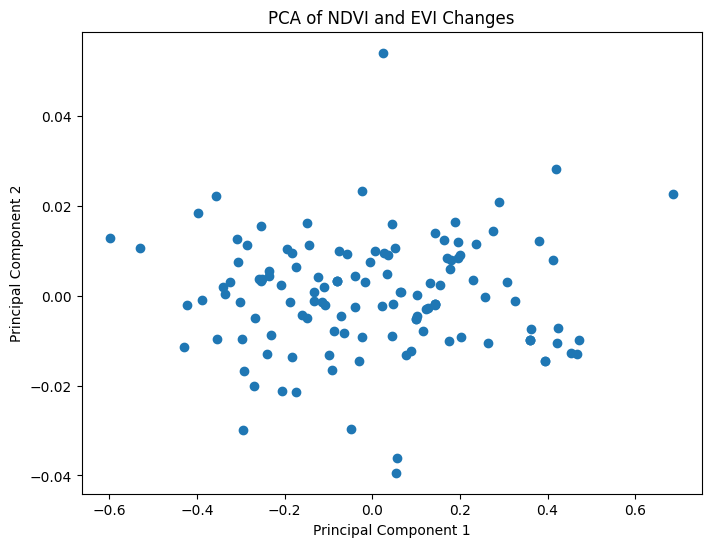

Explained variance by component: [0.99734437 0.00265563]


In [216]:
# @title
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

data = np.column_stack((df2['NDVI_change'], df2['EVI_change']))

pca = PCA(n_components=2)
components = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of NDVI and EVI Changes')
plt.show()

print("Explained variance by component:", pca.explained_variance_ratio_)

In [221]:
# @title
import pandas as pd
import numpy as np
import scipy.stats as stats

ndvi_low_threshold = -0.01
ndvi_high_threshold = 0.01

df2['NDVI_change_category'] = pd.cut(df2['NDVI_change'],
                                     bins=[np.NINF, ndvi_low_threshold, ndvi_high_threshold, np.PINF],
                                     labels=['Low', 'Medium', 'High'])

evi_low_threshold = -0.2
evi_high_threshold = 0.2

df2['EVI_change_category'] = pd.cut(df2['EVI_change'],
                                    bins=[np.NINF, evi_low_threshold, evi_high_threshold, np.PINF],
                                    labels=['Low', 'Medium', 'High'])

In [222]:
# @title
anova_result_ndvi = stats.f_oneway(df2[df2['NDVI_change_category'] == 'Low']['NDVI_change'],
                                   df2[df2['NDVI_change_category'] == 'Medium']['NDVI_change'],
                                   df2[df2['NDVI_change_category'] == 'High']['NDVI_change'])

print("ANOVA Result for NDVI Change:", anova_result_ndvi)

anova_result_evi = stats.f_oneway(df2[df2['EVI_change_category'] == 'Low']['EVI_change'],
                                  df2[df2['EVI_change_category'] == 'Medium']['EVI_change'],
                                  df2[df2['EVI_change_category'] == 'High']['EVI_change'])

print("ANOVA Result for EVI Change:", anova_result_evi)

ANOVA Result for NDVI Change: F_onewayResult(statistic=179.55734110211583, pvalue=2.404527979858593e-37)
ANOVA Result for EVI Change: F_onewayResult(statistic=180.21755271584306, pvalue=2.03019060688366e-37)


#### EVI Relacion a NDVI en Areas Marcados

In [224]:
# @title
ndvi_high_change_threshold = df2['NDVI_change'].mean() + df2['NDVI_change'].std()

ndvi_gain_mask = df2['NDVI_change'] > ndvi_high_change_threshold
ndvi_loss_mask = df2['NDVI_change'] < -ndvi_high_change_threshold

In [225]:
# @title
evi_change_in_ndvi_gain = df2[ndvi_gain_mask]['EVI_change']

evi_change_in_ndvi_loss = df2[ndvi_loss_mask]['EVI_change']

In [226]:
# @title
evi_change_gain_summary = evi_change_in_ndvi_gain.describe()

evi_change_loss_summary = evi_change_in_ndvi_loss.describe()

#### ____

In [227]:
# @title
overall_evi_change_summary = df2['EVI_change'].describe()

print("EVI Change in Areas of NDVI Gain:\n", evi_change_gain_summary)
print("\nEVI Change in Areas of NDVI Loss:\n", evi_change_loss_summary)
print("\nOverall EVI Change:\n", overall_evi_change_summary)

EVI Change in Areas of NDVI Gain:
 count    22.000000
mean     -0.284137
std       0.274739
min      -0.627823
25%      -0.542601
50%      -0.238983
75%      -0.075178
max       0.139553
Name: EVI_change, dtype: float64

EVI Change in Areas of NDVI Loss:
 count    15.000000
mean     -0.073351
std       0.364158
min      -0.843777
25%      -0.273862
50%      -0.008529
75%       0.175902
max       0.442707
Name: EVI_change, dtype: float64

Overall EVI Change:
 count    127.000000
mean      -0.156372
std        0.247241
min       -0.843777
25%       -0.322902
50%       -0.150598
75%        0.029893
max        0.442707
Name: EVI_change, dtype: float64


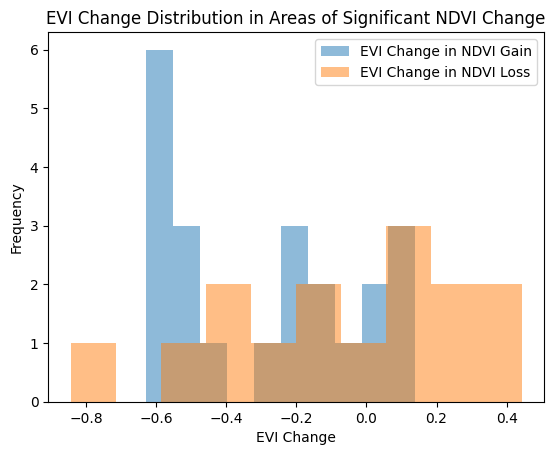

In [228]:
# @title
import matplotlib.pyplot as plt

plt.hist(evi_change_in_ndvi_gain, alpha=0.5, label='EVI Change in NDVI Gain')
plt.hist(evi_change_in_ndvi_loss, alpha=0.5, label='EVI Change in NDVI Loss')
plt.legend()
plt.title('EVI Change Distribution in Areas of Significant NDVI Change')
plt.xlabel('EVI Change')
plt.ylabel('Frequency')
plt.show()

# **Reporte**

## **Informe de Acción Basado en Análisis de NDVI y EVI**

### Resumen Ejecutivo:

El análisis de los cambios en los índices de vegetación NDVI y EVI indica patrones significativos de cambio en la cobertura vegetal entre dos periodos de tiempo. Aunque el NDVI se mantuvo relativamente estable, se observó una disminución promedio en el EVI, lo que puede indicar estrés en la vegetación o cambios en la calidad de la misma que no se detectan mediante el NDVI.

### Análisis de Cambios Significativos:

El análisis de varianza (ANOVA) demostró diferencias significativas en los cambios de NDVI y EVI, lo que sugiere que los cambios observados son sistemáticos y no aleatorios. La regresión OLS reveló una relación inversa entre el cambio en NDVI y EVI, aunque esta relación es débil, como lo indica el valor R-squared de 0.046.

### Recomendaciones para la Gestión de la Cosecha de Madera:

#### **1. Monitoreo Reforzado:**

Implementar un sistema de monitoreo mejorado en áreas donde se identificaron cambios significativos en el EVI para investigar las causas subyacentes de estos cambios.

#### **2. Prácticas de Cosecha Selectiva:**

Promover prácticas de cosecha selectiva que minimicen el impacto en la salud de la vegetación, manteniendo la cobertura del dosel y apoyando la recuperación rápida de la vegetación.


#### **3. Programas de Reforestación:**

Priorizar la reforestación en áreas con disminuciones significativas de EVI para restaurar el equilibrio ecológico y mejorar la salud de la vegetación.

### Investigación y Análisis Adicionales Necesarios:


#### **1. Factores Conducentes:**

Investigar factores adicionales que pueden influir en los cambios observados, incluyendo datos de uso de suelo y condiciones climáticas.

#### **2. Análisis Espacial Detallado:**

Realizar un análisis espacial detallado utilizando herramientas SIG para superponer los cambios observados en mapas de uso de suelo, áreas protegidas y otros datos relevantes.

### Políticas y Permisos para la Cosecha de Madera:

* Las políticas de permisos para la cosecha de madera deben ser informadas por los resultados del monitoreo, adaptándose a las condiciones cambiantes de la vegetación y las prácticas de cosecha sostenible.
* Deben establecerse límites en la cantidad y frecuencia de la cosecha de madera en áreas donde se ha identificado una disminución significativa en la salud de la vegetación.
* Incentivar prácticas de gestión forestal comunitaria que incluyan capacitación en prácticas sostenibles y sistemas de monitoreo y reporte.

### Conclusión:

Los resultados del análisis apuntan a la necesidad de un enfoque adaptativo y basado en datos para la gestión forestal. Las prácticas de cosecha deben alinearse con los objetivos de desarrollo sostenible, asegurando la salud a largo plazo y la productividad de los recursos forestales.

##**Sugerencias para una mayor exploración y conocimientos prácticos:**

### 1. Temperatura de la superficie terrestre
### 2. Densidad del bosque
### 3. Cambio de biomasa
### 4. Degradación
### 5. Cambio de carbono